# Transformers' homework

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this assignment, we offer you to develop your own Transformer model from scratch and implement it for time series data. The homework consists of the following elements:
* Obligatory tasks:
    + Part 1 ($6$ tasks, total $35$ points): Transformer model implementation;
    + Part 2 ($3$ tasks, total $25$ points): testing the developed Transformer model on the real dataset (namely, ETT).
* Bonus task ($2$ tasks, total $20$ points).

So, the maximum number of points that can be scored is $60$. You also can get $20$ extra points with the bonus task (maximum $15$ points for the first bonus task or maximum $20$ points for both the first and the second bonus tasks).

## Part 1: Transformer implementation

In this part, we offer you to implement the original variant of the Transformer model proposed in the paper ["Attention is all you need"](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). The attention seminar can be useful for completing some of the tasks.  

The general Transformer architecture:

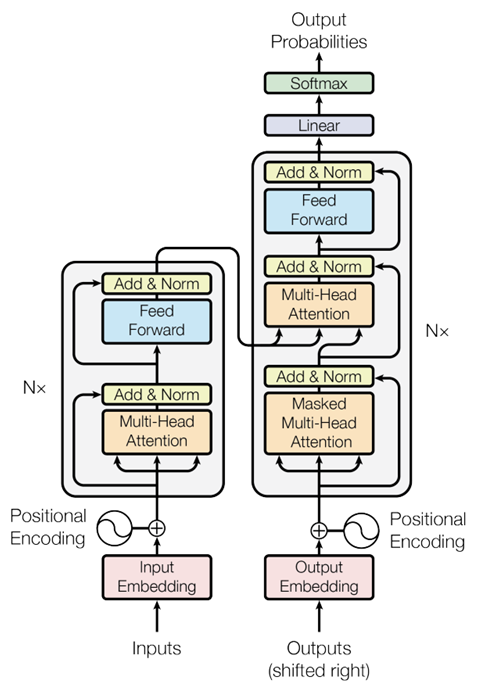

In [2]:
import numpy as np
import math

import torch
import torch.nn as nn

from typing import List, Tuple

#### Task 1 (5 points): implement the function calculates attention matrix and weighted values sum

To calculate the attention matrix, use the vectors' operations (as we discussed during the seminar):
\begin{align}
 \text{A}(Q, K) = \text{Softmax}(\frac{QK^T}{\sqrt{d_k}}),
\end{align}
where the expression under the softmax is the coefficient matrix.

The output of the attention block is a weighted sum of values:
\begin{align}
 O_k = \sum^n_{i = 1} a_{k i} v_i = A_k V.
\end{align}

The scheme:

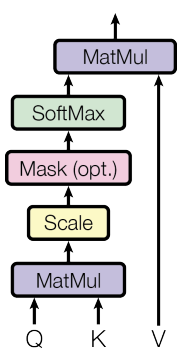

In [3]:
def attention(
        query: torch.tensor,
        key: torch.tensor,
        value: torch.tensor
) -> Tuple[torch.tensor, torch.tensor]:
    """Calculate attention matrix and weighted values sum.

    :param query: query tensor of shape [batch_size, sequence_length, number_of_features]
    :param key: query tensor of shape [batch_size, sequence_length, number_of_features]
    :param value: query tensor of shape [batch_size, sequence_length, number_of_features]

    :return: tuple of attention matrix and weighted values sum
    """
    d = query.shape[-1]
    coefficient_matrix = torch.matmul(query,key.transpose(-2,-1))/math.sqrt(d)
    attention_matrix = torch.softmax(coefficient_matrix, dim=-1)
    out = torch.matmul(attention_matrix,value)
    return attention_matrix, out

#### Task 2 (5 points): implement the attention class

First, you need to create queries, keys, and values using linear projections. Then, implement the function above to calculate the attention matrix and the output.  

$\textbf{NB}$: during the seminar, we considered the projections of the same sizes. Here, we offer you to use different sizes.

In [4]:
class Attention(nn.Module):
    """Implement the attention mechanism."""
    def __init__(
        self,
        dim_in: int,
        dim_q: int,
        dim_k: int,
    ):
        """Initialize linear projection layers.

        :param dim_in: the dimension of input
        :param dim_q: the dimension of query
        :param dim_k: the dimension of key and value
        """
        super().__init__()

        self.q = torch.nn.Linear(dim_in,dim_q) #layer for linear projection
        self.k = torch.nn.Linear(dim_in, dim_k, bias=False) #layer for linear projection
        self.v = torch.nn.Linear(dim_in, dim_k) #layer for linear projection

    def forward(
        self,
        query: torch.tensor,
        key: torch.tensor,
        value: torch.tensor
) -> Tuple[torch.tensor, torch.tensor]:
        """Get query, key and value projections and calculate attention matrix and weighted values sum.

        :param query: query tensor of shape [batch_size, sequence_length, number_of_features]
        :param key: query tensor of shape [batch_size, sequence_length, number_of_features]
        :param value: query tensor of shape [batch_size, sequence_length, number_of_features]

        :return: tuple of attention matrix and weighted values sum
        """
        query = self.q(query) #linear projection of query
        key = self.k(key) #linear projection of key
        value = self.v(value) #linear projection of value


        self.A, out = attention(query, key, value)

        return out

#### Task 3 (5 points): complete multi-head attention implementation

Multi-head attention consists of several (h -- the number of heads) attention layers running in parallel:

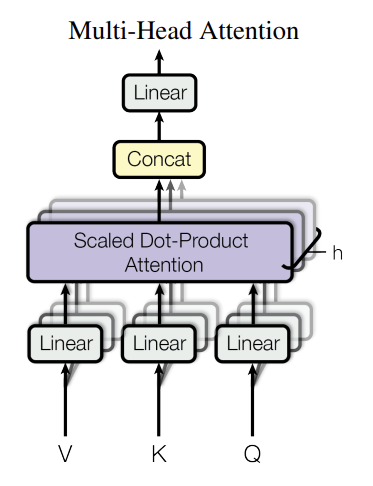

In [5]:
class MultiHeadAttention(nn.Module):
    """Implement Multihead attention"""
    def __init__(
        self,
        num_heads: int,
        dim_in: int,
        dim_q: int,
        dim_k: int,
    ):
        """Initialize Multihead attention.

        :param num_heads: the number of heads
        :param dim_in: the dimension of input
        :param dim_q: the dimension of query
        :param dim_k: the dimension of key and value
        """
        super().__init__()
        self.heads = nn.ModuleList(
            [
                Attention(dim_in, dim_q, dim_k) for _ in range(num_heads)
            ]
        )
        self.linear = nn.Linear(num_heads * dim_k, dim_in)

    def forward(
        self,
        query: torch.tensor,
        key: torch.tensor,
        value: torch.tensor
) -> Tuple[torch.tensor, torch.tensor]:
        """Get output of all attention heads.

        :param query: query tensor of shape [batch_size, sequence_length, number_of_features]
        :param key: query tensor of shape [batch_size, sequence_length, number_of_features]
        :param value: query tensor of shape [batch_size, sequence_length, number_of_features]

        :return: projection of concatenated output of all attention heads (aggregated output of all attention heads)
        """
        heads_outputs = [head(query,key,value) for head in self.heads]#: get outputs of all heads
        return self.linear(torch.cat(heads_outputs,dim=-1))# aggregate them using concatenation and linear layer

#### Task 4 (5 points): complete the code for the residual connection

The authors employ a residual connection around each of the two sub-layers, followed by layer normalization. So, the output of each sub-layer is:
\begin{align}
\text{LayerNorm}(x + \text{Sublayer}(x)),
\end{align}
where $\text{Sublayer}(x)$ is the function implemented by the sub-layer itself. Do not forget to add dropout after $\text{Sublayer}(x)$.

<!-- ![residual](residual_block.png) -->
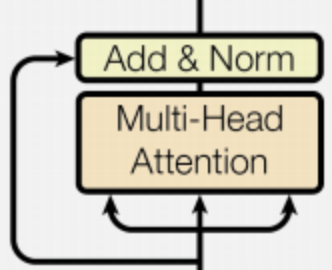

In [6]:
class Residual(nn.Module):
    def __init__(
        self,
        sublayer: nn.Module,
        dimension: int,
        dropout: float = 0.1,
    ):
        """Initialize Resisual connection class.

        :param sublayer: the layer included in residual connection (in case, it will be MultiHeadAttention layer)
        :param dimension: the dimension along which layer normalization implements
        :param dropout: the dropout probability
        """
        super().__init__()
        self.sublayer = sublayer
        self.norm = nn.LayerNorm(dimension)
        self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        *tensors: List[torch.tensor],
    ) -> torch.tensor:

        """Get output of residual connection block.
        :param tensors: list of input tensor of sublayer
        :return: output of residual connection block (as depicted in figure above)
        """

        output = self.sublayer(*tensors)
        output = self.norm(output)
        output = self.dropout(output)
        output = output + tensors[0]
        return output

#### Task 5 (10 points): implement Transformer encoder

Now, it's time to implement the whole encoder architecture. We offer you to code one Transformer encoder layer first and, second, generalize the Transformer encoder via positional encoding addition and implementation of several Transformer encoder layers.

* 5 points -- Transformer encoder layer.
* 5 points -- Transformer encoder with positional encoding.

The one encoder's layer architecture:

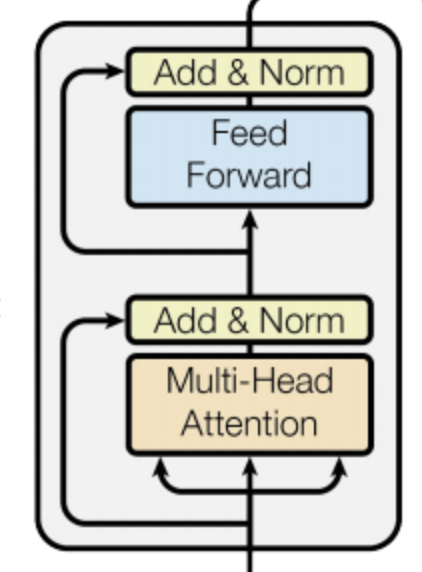
<!-- ![encoder](encoder.png) -->

In [7]:
class TransformerEncoderLayer(nn.Module):
    def __init__(
        self,
        dim_model: int = 512,
        num_heads: int = 8,
        dim_feedforward: int = 1024,
        dropout: float = 0.1,
    ):
        """Initialize Transformer encoder layer.

        :param dim_model: the dimension of input
        :param num_heads: the number of heads
        :param dim_feedforward: the dimension of feed-forward part
        :param dropout: the dropout probability
        """
        super().__init__()
        dim_q = dim_k = max(dim_model // num_heads, 1)

        self.attention = Residual(MultiHeadAttention(num_heads,dim_model,dim_q,dim_k),
                                  dimension = dim_model,
                                  dropout = dropout)# TODO: implement residual connection of multihead attention layer

        ff = nn.Sequential(
            nn.Linear(dim_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, dim_model),
        )
        self.feed_forward = Residual(ff,
                                     #dimension = dim_feedforward,
                                     dimension = dim_model,
                                     dropout = dropout) # TODO: implement residual connection of feed-forward net

    def forward(self, src) -> torch.tensor:
        """Get the output of Transformer encoder layer.

        :param src: input

        :return: output of Transformer encoder layer
        """
        return self.feed_forward(self.attention(src, src, src))

Positional encoding can be used to introduce the sequential nature of data to our model. It allows our model to consider the order of elements in a sequence. The original paper ("Attention is all you need") proposed the sinusoid-based positional encoding:   

$PE(pos, 2i) = \sin(pos / 1000^{2i/d_{model}})$

$PE(pos, 2i+1) = \cos(pos / 1000^{2i/d_{model}})$

We offer to use this variant, too. The one encoder's layer architecture:

In [8]:
def sinusoid_position_encoding(
    seq_len: int,
    dim_model: int,
    device: torch.device = torch.device("cuda"),
) -> torch.tensor:
    """implement positional encoding.

    :param seq_len: the length of input sequence
    :param dim_model: the dimention of model
    :param device: the computational device

    :return: positional encoding
    """

    pe = torch.zeros(seq_len,dim_model).to(device)
    position = torch.arange(0,seq_len).unsqueeze(1).to(device)
    div_term = torch.exp(torch.arange(0,dim_model,2)*-(math.log(1000.0)/dim_model)).to(device)
    pe[:,0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

In [9]:
class TransformerEncoder(nn.Module):
    def __init__(
        self,
        num_layers: int = 6,
        dim_model: int = 512,
        num_heads: int = 8,
        dim_feedforward: int = 1024,
        dropout: float = 0.1,
        position_encoding: callable = sinusoid_position_encoding,
    ):
        """Initialize Transformer encoder.

        :param num_layers: the number of encoder layers
        :param dim_model: the dimension of input
        :param num_heads: the number of heads
        :param dim_feedforward: the dimension of feed-forward part
        :param dropout: the dropout probability
        :param position_encoding: positional encoding function
        """
        super().__init__()
        self.layers = nn.ModuleList(
            [
                TransformerEncoderLayer(dim_model, num_heads, dim_feedforward, dropout)
                for _ in range(num_layers)
            ]
        )
        self.position_encoding = position_encoding

    def forward(self, src: torch.tensor) -> torch.tensor:
        """Get the output of Transformer encoder.

        :param src: input

        :return: output of Transformer encoder
        """
        seq_len, dimension = src.shape[1], src.shape[2]
        src += self.position_encoding(seq_len, dimension)# TODO: add positional encodeing

        # TODO: get output of all layers
        for layer in self.layers:
            src = layer(src)
        return src

#### Task 6 (5 points): implement Transformer decoder

Similarly to the encoder, implement the Transformer decoder layer and Transformer decoder.

The one decoder's layer architecture:


<!-- ![decoder](decoder.png) -->
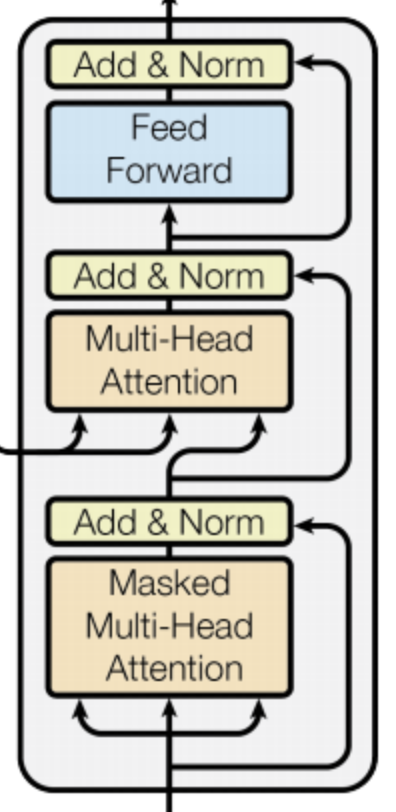



In [10]:
class TransformerDecoderLayer(nn.Module):
    def __init__(
        self,
        dim_model: int = 512,
        num_heads: int = 6,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
    ):
        """Initialize Transformer decoder layer.

        :param dim_model: the dimension of input
        :param num_heads: the number of heads
        :param dim_feedforward: the dimension of feed-forward part
        :param dropout: the dropout probability
        """
        super().__init__()
        dim_q = dim_k = max(dim_model // num_heads, 1)
        self.attention_1 = Residual(MultiHeadAttention(num_heads,dim_model,dim_q,dim_k),
                                  dimension = dim_model,
                                  dropout = dropout)# TODO: implement residual connection of multihead attention layer
        self.attention_2 = Residual(MultiHeadAttention(num_heads,dim_model,dim_q,dim_k),
                                  dimension = dim_model,
                                  dropout = dropout)# TODO: implement residual connection of multihead attention layer
        ff = nn.Sequential(
            nn.Linear(dim_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, dim_model),
        )
        self.feed_forward = Residual(ff,
                                     dimension = dim_model,
                                     dropout = dropout)

        #self.feed_forward = # TODO: implement feed-forward net

    def forward(
        self,
        target: torch.tensor,
        memory: torch.tensor
    ) -> torch.tensor:
        """Get the output of Transformer decoder layer.

        :param target: target sequence
        :param memory: encoder's output

        :return: output of Transformer decoder layer
        """
        target = self.attention_1(target, target, target)
        target = self.attention_2(target, memory, memory)
        return self.feed_forward(target)

In [11]:
class TransformerDecoder(nn.Module):
    def __init__(
        self,
        num_layers: int = 6,
        dim_model: int = 512,
        num_heads: int = 8,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
        position_encoding=sinusoid_position_encoding,
    ):
        """Initialize Transformer decoder.

        :param num_layers: the number of decoder layers
        :param dim_model: the dimension of input
        :param num_heads: the number of heads
        :param dim_feedforward: the dimension of feed-forward part
        :param dropout: the dropout probability
        :param position_encoding: positional encoding function
        """
        super().__init__()
        self.layers = nn.ModuleList(
            [
                TransformerDecoderLayer(dim_model, num_heads, dim_feedforward, dropout)
                for _ in range(num_layers)
            ]
        )
        #self.layers = # TODO: implement decoder layers
        self.linear = nn.Linear(dim_model, dim_model)

        self.position_encoding = position_encoding

    def forward(self, target: torch.tensor, memory: torch.tensor) -> torch.tensor:
        """Get the output of Transformer decoder layer.

        :param target: target sequence
        :param memory: encoder's output

        :return: output of Transformer decoder
        """
        seq_len, dimension = target.size(1), target.size(2)
        target += self.position_encoding(seq_len, dimension)# TODO: add positional encoding

        # TODO: get output of all layers
        for layer in self.layers:
            target = layer(target,memory)
        return torch.softmax(self.linear(target), dim=-1)

#### The whole model:

In [12]:
class Transformer(nn.Module):
    def __init__(
        self,
        input_size,
        d_model,
        n_heads,
        e_layers,
        d_layers,
        d_ff,
        dropout,
        device
    ):
        """Initialize Transformer model.

        :param input_size: the dimension of input
        :param d_model: the dimension of encoder and decoder
        :param num_heads: the number of heads
        :param e_layers: the number of encoder layers
        :param d_layers: the number of decoder layers
        :param d_ff: the dimension of feed-forward part
        :param dropout: the dropout probability
        :param device: device of computation
        """

        super().__init__()

        self.embedding = nn.Linear(input_size, d_model).to(device)
        self.encoder = TransformerEncoder(dim_model=d_model,
                                          num_heads=n_heads,
                                          num_layers=e_layers,
                                          dim_feedforward=d_ff,
                                          dropout=dropout).to(device)

        self.decoder = TransformerDecoder(dim_model=d_model,
                                          num_heads=n_heads,
                                          num_layers=d_layers,
                                          dim_feedforward=d_ff,
                                          dropout=dropout).to(device)

        self.output = nn.Linear(d_model, input_size).to(device)

    def forward(
        self,
        src,
        target
    ):
        """Get the output of Transformer model.

        :param src: input sequence
        :param target: target sequence

        :return: output of Transformer model
        """

        src = self.embedding(src)
        target = self.embedding(target)

        encoder_output = self.encoder(src)
        decoder_output = self.decoder(target, encoder_output)

        return self.output(decoder_output)

## Part 2: testing

We offer you to test your model on [ETT dataset](https://github.com/zhouhaoyi/ETDataset). In the following cells, we provide the code for its loading and processing.

In [13]:
!git clone https://github.com/zhouhaoyi/ETDataset.git
!git clone https://github.com/zhouhaoyi/Informer2020.git

Cloning into 'ETDataset'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 187 (delta 25), reused 20 (delta 20), pack-reused 159
Receiving objects: 100% (187/187), 3.86 MiB | 12.19 MiB/s, done.
Resolving deltas: 100% (62/62), done.
Cloning into 'Informer2020'...
remote: Enumerating objects: 576, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 576 (delta 0), reused 2 (delta 0), pack-reused 573
Receiving objects: 100% (576/576), 6.49 MiB | 15.70 MiB/s, done.
Resolving deltas: 100% (328/328), done.


In [40]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [41]:
import pandas as pd
import os

data_root = './ETDataset/ETT-small/'
data = pd.read_csv(os.path.join(data_root, 'ETTh1.csv'))
data.shape

(17420, 8)

In [42]:
from data.data_loader import Dataset_ETT_hour
from torch.utils.data import DataLoader

In [43]:
seq_len = 96 # length of input sequence of encoder
label_len = 48 # starting length of token of decoder
pred_len = 24 # length of predicted sequence

batch_size = 128

dataset_args = {
    "root_path": data_root,
    "data_path": "ETTh1.csv",
    "size": [seq_len, label_len, pred_len],
    "features": "M", # possible variants: [M, S, MS], where M: multivariate prediction of multivariate, S: one-dimensional prediction of one-dimensional, MS: multivariate prediction of one-dimensional
    "target": "OT",
    "inverse": False,
    "timeenc": 0,
    "freq": "h", # frequency for encoding time characteristics, parameters: [s: every second, t: every minute, h: hourly, d: daily, b: working days, w: weekly, m: monthly]; you can also use a more detailed frequency, for example, 15 minutes or 3 hours
}
dataset_ett_train = Dataset_ETT_hour(flag='train', **dataset_args)
dataset_ett_val = Dataset_ETT_hour(flag='val', **dataset_args)
dataset_ett_test = Dataset_ETT_hour(flag='test', **dataset_args)

In [44]:
dataloader_args = {
    "batch_size": batch_size,
    "num_workers": 0,
    "drop_last": True,
}
train_loader = DataLoader(
    dataset_ett_train,
    shuffle=True,
    **dataloader_args,
)
val_loader = DataLoader(
    dataset_ett_val,
    shuffle=False,
    **dataloader_args,
)
test_loader = DataLoader(
    dataset_ett_test,
    shuffle=False,
    **dataloader_args,
)

In [20]:
d_model = 512
n_heads = 8
e_layers = 2
d_layers = 1
d_ff = 2048
dropout = 0.05

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transformer = Transformer(input_size=data.shape[1]-1,
                          d_model=d_model,
                          n_heads=n_heads,
                          e_layers=e_layers,
                          d_layers=d_layers,
                          d_ff=d_ff,
                          dropout=dropout,
                          device = device)

In [45]:
transformer_optim = torch.optim.Adam(transformer.parameters(), lr=0.001)
criterion = nn.MSELoss()

#### Task 7 (10 points): complete training and validation processes

Let's train the model! Before that, complete the training and validation loops. During training, for each element from the dataloader, you have to obtain predictions using the Transformer model, calculate the mean squared error between the predicted and true values, and make a step of the optimizer. During validation, only the calculation of the loss function between true and predicted values is required. Do not forget to switch the model to the training and evaluation modes.  

* 5 points -- training step.
* 3 points -- validation step.
* 2 points -- visualization of loss functions (the cell under the cell below).

In [38]:
def chkpoint(model,epoch, path = 'drive/MyDrive/MOSD'):
  torch.save(model.state_dict(), os.path.join(path,str(epoch)+'_new.pth'))

In [ ]:
from tqdm import tqdm

train_loss_epoch = []
val_loss_epoch = []
epochs = 20 # TODO: choose the number of training epochs
transformer.to(device)
with torch.autograd.set_detect_anomaly(True):
    print("starting training")
    for epoch in tqdm(range(epochs)):
        print(f'\nepoch {epoch+1}')
        train_loss = []

        #########
        # TRAIN #
        #########
        transformer.train(True)
        for data in train_loader:
            transformer_optim.zero_grad()
            src, tgt, _, _ = data
            src = src.to(device).to(torch.float32)
            tgt = tgt.to(device).to(torch.float32)


            output = transformer(src,tgt)

            loss = criterion(output, tgt)
            loss.backward()
            transformer_optim.step()

            train_loss.append(loss.item())
        train_loss_epoch.append(sum(train_loss)/len(train_loss))

        if not epoch%2:
          chkpoint(transformer,epoch)

        #######
        # VAL #
        #######
        transformer.train(False)
        val_loss = []
        with torch.autograd.no_grad():
            for data in val_loader:
                src, tgt,_,_ = data
                src = src.to(device).to(torch.float32)
                tgt = tgt.to(device).to(torch.float32)

                output = transformer(src,tgt)

                loss = criterion(output, tgt)

                val_loss.append(loss.item())

            val_loss_epoch.append(sum(val_loss)/len(val_loss))
        print(f'\nend of epoch {epoch+1}\n train loss: {train_loss_epoch[-1]}\n val loss {val_loss_epoch[-1]}')

starting training


  0%|          | 0/20 [00:00<?, ?it/s]


epoch 1


  5%|▌         | 1/20 [00:46<14:51, 46.91s/it]


end of epoch 1
 train loss: 0.9465330143769582
 val loss 1.4089152352376417

epoch 2


 10%|█         | 2/20 [01:32<13:48, 46.03s/it]


end of epoch 2
 train loss: 0.8744554591901375
 val loss 1.347097334536639

epoch 3


 15%|█▌        | 3/20 [02:18<12:59, 45.88s/it]


end of epoch 3
 train loss: 0.8129389800808646
 val loss 1.2940430424430154

epoch 4


 20%|██        | 4/20 [03:02<12:04, 45.28s/it]


end of epoch 4
 train loss: 0.7593829315720182
 val loss 1.248150261965665

epoch 5


 25%|██▌       | 5/20 [03:48<11:25, 45.69s/it]


end of epoch 5
 train loss: 0.7109838019717823
 val loss 1.2048557888377796

epoch 6


 30%|███       | 6/20 [04:33<10:35, 45.41s/it]


end of epoch 6
 train loss: 0.6662642079772372
 val loss 1.1662502058527686

epoch 7


 35%|███▌      | 7/20 [05:18<09:49, 45.37s/it]


end of epoch 7
 train loss: 0.6267192535328142
 val loss 1.1318515159867026

epoch 8


 40%|████      | 8/20 [06:03<09:00, 45.05s/it]


end of epoch 8
 train loss: 0.59045205152396
 val loss 1.0951433750716122

epoch 9


 45%|████▌     | 9/20 [06:48<08:17, 45.21s/it]


end of epoch 9
 train loss: 0.5571401922991781
 val loss 1.0637361651117152

epoch 10


 50%|█████     | 10/20 [07:34<07:32, 45.22s/it]


end of epoch 10
 train loss: 0.5262915582367869
 val loss 1.033530368046327

epoch 11


 55%|█████▌    | 11/20 [08:18<06:45, 45.02s/it]


end of epoch 11
 train loss: 0.49844122474843805
 val loss 1.0053285035220059

epoch 12


 60%|██████    | 12/20 [09:07<06:10, 46.29s/it]


end of epoch 12
 train loss: 0.4738532318310304
 val loss 0.978548223322088

epoch 13


 65%|██████▌   | 13/20 [09:52<05:19, 45.70s/it]


end of epoch 13
 train loss: 0.45093758494564984
 val loss 0.9536291320215572

epoch 14


 70%|███████   | 14/20 [10:37<04:34, 45.72s/it]


end of epoch 14
 train loss: 0.4299577871958415
 val loss 0.931154493581165

epoch 15


 75%|███████▌  | 15/20 [11:24<03:49, 45.83s/it]


end of epoch 15
 train loss: 0.4106181006539952
 val loss 0.9084906788034872

epoch 16


 80%|████████  | 16/20 [12:08<03:01, 45.47s/it]


end of epoch 16
 train loss: 0.3933076140555469
 val loss 0.8882493789900433

epoch 17


 85%|████████▌ | 17/20 [12:52<02:15, 45.08s/it]


end of epoch 17
 train loss: 0.3774693391539834
 val loss 0.8694058528000658

epoch 18


 90%|█████████ | 18/20 [13:38<01:30, 45.23s/it]


end of epoch 18
 train loss: 0.3628997296997995
 val loss 0.8502267294309356

epoch 19


 95%|█████████▌| 19/20 [14:23<00:45, 45.22s/it]


end of epoch 19
 train loss: 0.3493591686992934
 val loss 0.8305121599273249

epoch 20


100%|██████████| 20/20 [15:08<00:00, 45.41s/it]


end of epoch 20
 train loss: 0.3374460705301978
 val loss 0.8148388652638956


Visualize the training and validation MSE, put the two plots in one figure.

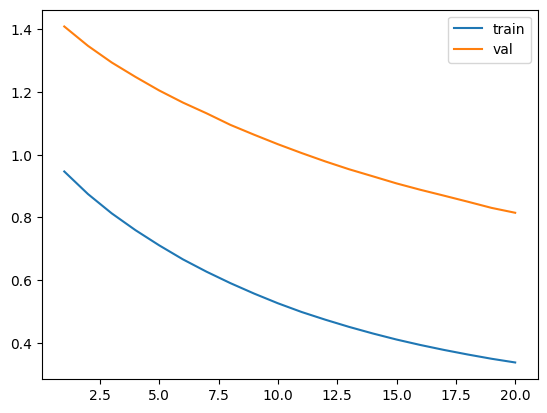

In [ ]:
import matplotlib.pyplot as plt

# TODO: plot the training and validaiton loss

plt.plot(range(1,epochs+1), train_loss_epoch, label = 'train')
plt.plot(range(1,epochs+1), val_loss_epoch, label = 'val')
plt.legend()

In [ ]:
# TODO: analyze the obtained figure and answer the questions: Has the model been trained? Are there any overfitting signs?
# You can put your answer here or insert the markdown below.

The model has been trained, but there are still some more epochs left to train since both the training and validation errors are decreasing.

On the other hand, a significant difference between the training and validation mean squared error on epoch 20 (approximately 0.5), as well as a comparatively low training MSE, may be signs of overfitting.


#### Task 8 (5 points): visualize the example of your predictions on testing data
You have already visualized the loss, but how good are the predictions? To analyze it, we offer you to do the following:

1. Choose a data example from the test part and obtain the Transformer's prediction.
2. Visualize the ground truth time series example and the Transformer's prediction.

In [ ]:
# TODO: your code for the example choosing

# Choose a data example from the test set
example_idx = 0
src, target,_,_ = dataset_ett_test[example_idx]
src = torch.from_numpy(src).unsqueeze(0).to(device).to(torch.float32)
target = torch.from_numpy(target).unsqueeze(0).to(device).to(torch.float32)

# Obtain the Transformer's prediction
transformer.eval()
with torch.no_grad():
    output = transformer(src, target)

# Convert tensors to numpy arrays
src = src.squeeze(0).cpu().numpy()
target = target.squeeze(0).cpu().numpy()
output = output.squeeze(0).cpu().numpy()



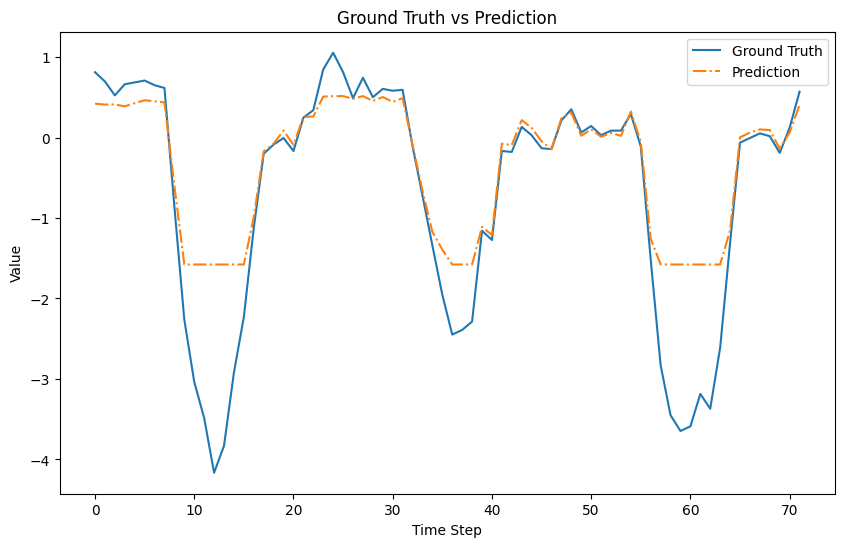

In [ ]:
# TODO: your code for the visualization

k = 1
plt.figure(figsize=(10, 6))
plt.plot(target[:,:k], label='Ground Truth')
plt.plot(output[:,:k], label='Prediction', ls="-.")
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Ground Truth vs Prediction')
plt.legend()
plt.show()

#### Task 9 (10 points): analyze the model

Is its quality good? How to improve it?

Basically, the model catches the main trend but has some problems with outliers dots.

Hyperparameter search could be a solution of such problem

#### Bonus: task 10 (20 points)

The quality of the obtained Transformer model can be improved during the hyperparameter search. We offer you (as the bonus task) to conduct the hyperparameter optimization with the framework [Optuna](https://optuna.org/).

* 15 points -- Conduct the hyperparameter optimization.
* 5 points  -- Compare the previous model with the model obtained during the hyperparameter optimization. How much has the quality of the model changed?

In [22]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.5 MB/s eta 0:00:00


In [23]:
def train_and_eval(transformer):

    train_loss_epoch = []
    val_loss_epoch = []
    epochs = 10 # TODO: choose the number of training epochs
    transformer.to(device)

    with torch.autograd.set_detect_anomaly(True):
      #print("starting training")
      for epoch in range(epochs):
          train_loss = []

          #########
          # TRAIN #
          #########
          transformer.train(True)
          for data in train_loader:
              transformer_optim.zero_grad()
              src, tgt, _, _ = data
              src = src.to(device).to(torch.float32)
              tgt = tgt.to(device).to(torch.float32)


              output = transformer(src,tgt)

              loss = criterion(output, tgt)
              loss.backward()
              transformer_optim.step()

              train_loss.append(loss.item())
          train_loss_epoch.append(sum(train_loss)/len(train_loss))

          #######
          # VAL #
          #######
          transformer.train(False)
          val_loss = []
          with torch.autograd.no_grad():
              for data in val_loader:
                  src, tgt,_,_ = data
                  src = src.to(device).to(torch.float32)
                  tgt = tgt.to(device).to(torch.float32)

                  output = transformer(src,tgt)

                  loss = criterion(output, tgt)

                  val_loss.append(loss.item())

              val_loss_epoch.append(sum(val_loss)/len(val_loss))
          #print(f'\nend of epoch {epoch+1}\n train loss: {train_loss_epoch[-1]}\n val loss {val_loss_epoch[-1]}')
    return val_loss_epoch[-1]

In [24]:
import optuna

def objective(trial):
    d_model = 512
    n_heads = trial.suggest_int('n_heads', 2, 16)
    e_layers = trial.suggest_int('e_layers', 1, 4)
    d_layers = trial.suggest_int('d_layers', 1, 4)
    d_ff = trial.suggest_int('d_ff', 512, 4096)
    dropout = trial.suggest_uniform('dropout', 0.0, 0.5)

    transformer = Transformer(input_size=data.shape[1]-1,
                              d_model=d_model,
                              n_heads=n_heads,
                              e_layers=e_layers,
                              d_layers=d_layers,
                              d_ff=d_ff,
                              dropout=dropout,
                              device=device)

    transformer_optim = torch.optim.Adam(transformer.parameters(), lr=0.001)
    criterion = nn.MSELoss()


    val_loss = train_and_eval(transformer)
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

best_params = study.best_params
best_value = study.best_value

print("Best params:", best_params)
print("Best value:", best_value)


[I 2023-10-09 14:42:14,180] A new study created in memory with name: no-name-84f488fc-72eb-4eb5-b7eb-2fc03e35f566
[I 2023-10-09 14:57:06,702] Trial 0 finished with value: 1.4976386400786312 and parameters: {'n_heads': 14, 'e_layers': 1, 'd_layers': 2, 'd_ff': 2778, 'dropout': 0.293894858900496}. Best is trial 0 with value: 1.4976386400786312.
[I 2023-10-09 15:05:47,279] Trial 1 finished with value: 1.492662486704913 and parameters: {'n_heads': 3, 'e_layers': 3, 'd_layers': 3, 'd_ff': 1116, 'dropout': 0.15733565647754744}. Best is trial 1 with value: 1.492662486704913.
[I 2023-10-09 15:11:55,161] Trial 2 finished with value: 1.4993049177256497 and parameters: {'n_heads': 2, 'e_layers': 4, 'd_layers': 2, 'd_ff': 676, 'dropout': 0.4916000320833853}. Best is trial 1 with value: 1.492662486704913.
[I 2023-10-09 15:23:32,763] Trial 3 finished with value: 1.4895360876213422 and parameters: {'n_heads': 10, 'e_layers': 1, 'd_layers': 2, 'd_ff': 3117, 'dropout': 0.2924172068324773}. Best is tria

Best params: {'n_heads': 10, 'e_layers': 1, 'd_layers': 2, 'd_ff': 3117, 'dropout': 0.2924172068324773}
Best value: 1.4895360876213422


In [47]:
#old model
d_model = 512
n_heads = 8
e_layers = 2
d_layers = 1
d_ff = 2048
dropout = 0.05

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transformer_old = Transformer(input_size=data.shape[1]-1,
                          d_model=d_model,
                          n_heads=n_heads,
                          e_layers=e_layers,
                          d_layers=d_layers,
                          d_ff=d_ff,
                          dropout=dropout,
                          device = device)

transformer_old.load_state_dict(torch.load('drive/MyDrive/MOSD/18'))


#new model
d_model = 512
n_heads = 10
e_layers = 1
d_layers = 2
d_ff = 3117
dropout = 0.29

transformer_new = Transformer(input_size=data.shape[1]-1,
                              d_model=d_model,
                              n_heads=n_heads,
                              e_layers=e_layers,
                              d_layers=d_layers,
                              d_ff=d_ff,
                              dropout=dropout,
                              device=device)

transformer_optim = torch.optim.Adam(transformer_new.parameters(), lr=0.001)
criterion = nn.MSELoss()



In [48]:
from tqdm import tqdm

train_loss_epoch = []
val_loss_epoch = []
epochs = 20 # TODO: choose the number of training epochs
transformer_new.to(device)
with torch.autograd.set_detect_anomaly(True):
    print("starting training")
    for epoch in tqdm(range(epochs)):
        print(f'\nepoch {epoch+1}')
        train_loss = []

        #########
        # TRAIN #
        #########
        transformer_new.train(True)
        for data in train_loader:
            transformer_optim.zero_grad()
            src, tgt, _, _ = data
            src = src.to(device).to(torch.float32)
            tgt = tgt.to(device).to(torch.float32)


            output = transformer_new(src,tgt)

            loss = criterion(output, tgt)
            loss.backward()
            transformer_optim.step()

            train_loss.append(loss.item())
        train_loss_epoch.append(sum(train_loss)/len(train_loss))

        if not epoch%2:
          chkpoint(transformer_new,epoch)

        #######
        # VAL #
        #######
        transformer_new.train(False)
        val_loss = []
        with torch.autograd.no_grad():
            for data in val_loader:
                src, tgt,_,_ = data
                src = src.to(device).to(torch.float32)
                tgt = tgt.to(device).to(torch.float32)

                output = transformer_new(src,tgt)

                loss = criterion(output, tgt)

                val_loss.append(loss.item())

            val_loss_epoch.append(sum(val_loss)/len(val_loss))
        print(f'\nend of epoch {epoch+1}\n train loss: {train_loss_epoch[-1]}\n val loss {val_loss_epoch[-1]}')

starting training


  0%|          | 0/20 [00:00<?, ?it/s]


epoch 1


  5%|▌         | 1/20 [01:07<21:21, 67.43s/it]


end of epoch 1
 train loss: 0.945868146238905
 val loss 1.4105435203422199

epoch 2


 10%|█         | 2/20 [02:14<20:12, 67.34s/it]


end of epoch 2
 train loss: 0.8762948865240271
 val loss 1.338779697364027

epoch 3


 15%|█▌        | 3/20 [03:20<18:50, 66.51s/it]


end of epoch 3
 train loss: 0.8101989861690637
 val loss 1.2765089639208533

epoch 4


 20%|██        | 4/20 [04:26<17:45, 66.57s/it]


end of epoch 4
 train loss: 0.7559367905963551
 val loss 1.2246350849216634

epoch 5


 25%|██▌       | 5/20 [05:33<16:39, 66.60s/it]


end of epoch 5
 train loss: 0.7071320748690403
 val loss 1.1817329851063816

epoch 6


 30%|███       | 6/20 [06:40<15:32, 66.63s/it]


end of epoch 6
 train loss: 0.663693885008494
 val loss 1.1430655988779934

epoch 7


 35%|███▌      | 7/20 [07:46<14:26, 66.64s/it]


end of epoch 7
 train loss: 0.6252768942804048
 val loss 1.1088310791687532

epoch 8


 40%|████      | 8/20 [08:53<13:19, 66.64s/it]


end of epoch 8
 train loss: 0.5911642945174015
 val loss 1.078028219667348

epoch 9


 45%|████▌     | 9/20 [10:00<12:14, 66.82s/it]


end of epoch 9
 train loss: 0.5604440425381516
 val loss 1.051280589266257

epoch 10


 50%|█████     | 10/20 [11:08<11:10, 67.01s/it]


end of epoch 10
 train loss: 0.5315123281695626
 val loss 1.025764362378554

epoch 11


 55%|█████▌    | 11/20 [12:13<09:59, 66.63s/it]


end of epoch 11
 train loss: 0.5056002058766105
 val loss 1.0050474784590981

epoch 12


 60%|██████    | 12/20 [13:20<08:51, 66.46s/it]


end of epoch 12
 train loss: 0.48251153573845373
 val loss 0.97895647585392

epoch 13


 65%|██████▌   | 13/20 [14:27<07:47, 66.72s/it]


end of epoch 13
 train loss: 0.4605947741956422
 val loss 0.9574766497720372

epoch 14


 70%|███████   | 14/20 [15:34<06:40, 66.83s/it]


end of epoch 14
 train loss: 0.44027535301266296
 val loss 0.9366252015937458

epoch 15


 75%|███████▌  | 15/20 [16:40<05:33, 66.69s/it]


end of epoch 15
 train loss: 0.42157099147637683
 val loss 0.9175718819553201

epoch 16


 80%|████████  | 16/20 [17:46<04:25, 66.46s/it]


end of epoch 16
 train loss: 0.40356822402188275
 val loss 0.896553213623437

epoch 17


 85%|████████▌ | 17/20 [18:53<03:19, 66.66s/it]


end of epoch 17
 train loss: 0.3883181417530233
 val loss 0.8787177882411263

epoch 18


 90%|█████████ | 18/20 [20:00<02:13, 66.75s/it]


end of epoch 18
 train loss: 0.37260946902361786
 val loss 0.859879499131983

epoch 19


 95%|█████████▌| 19/20 [21:07<01:06, 66.63s/it]


end of epoch 19
 train loss: 0.3588918086254235
 val loss 0.842314479703253

epoch 20


100%|██████████| 20/20 [22:14<00:00, 66.73s/it]


end of epoch 20
 train loss: 0.34618770308566815
 val loss 0.8264122368259863


In [49]:
example_idx = 0
src, target,_,_ = dataset_ett_test[example_idx]
src = torch.from_numpy(src).unsqueeze(0).to(device).to(torch.float32)
target = torch.from_numpy(target).unsqueeze(0).to(device).to(torch.float32)

# Obtain the Transformer's prediction
transformer_old.eval()
transformer_new.eval()
with torch.no_grad():
    output_old = transformer_old(src, target)
    output_new = transformer_new(src, target)

# Convert tensors to numpy arrays
src = src.squeeze(0).cpu().numpy()
target = target.squeeze(0).cpu().numpy()
output_old = output_old.squeeze(0).cpu().numpy()
output_new = output_new.squeeze(0).cpu().numpy()

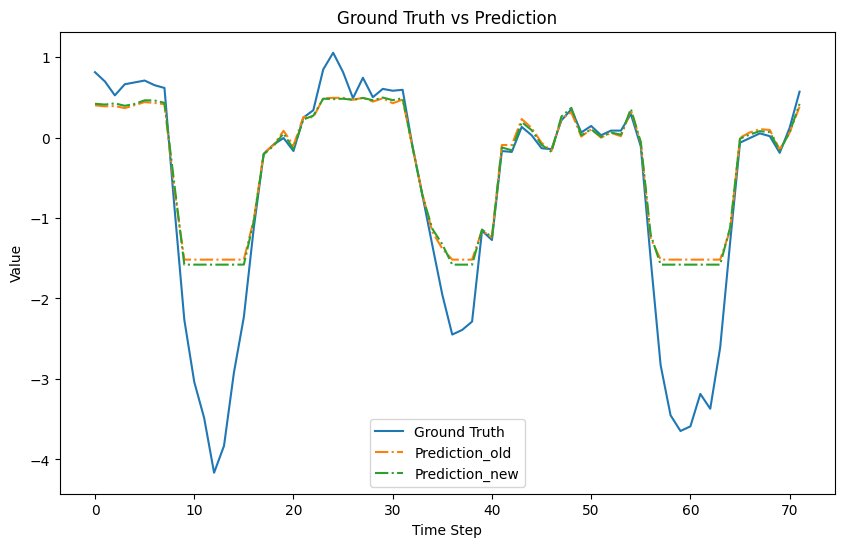

In [54]:
import matplotlib.pyplot as plt
k = 1
plt.figure(figsize=(10, 6))
plt.plot(target[:,:k], label='Ground Truth')
plt.plot(output_old[:,:k], label='Prediction_old', ls="-.")
plt.plot(output_new[:,:k], label='Prediction_new', ls="-.")
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Ground Truth vs Prediction')
plt.legend()
plt.show()